# **Store Item Demand Forecasting**

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Curabitur ornare, purus id finibus pellentesque, ligula ipsum bibendum turpis, et eleifend nisi mi eu tellus. Quisque efficitur sodales nisi eget gravida. Sed nec luctus tortor. Lorem ipsum dolor sit amet, consectetur adipiscing elit. Praesent porta dapibus vulputate. Etiam iaculis velit eget nisi blandit, vitae rhoncus ante congue. Duis iaculis vitae elit eu malesuada. Proin eu commodo odio. Etiam ligula mi, convallis eget nisl eu, tristique tempor enim. Sed et fermentum magna.

**Authors:**
- [Daniel Valdez](https://github.com/Danval-003)
- [Emilio Solano](https://github.com/emiliosolanoo21)
- [Adrian Flores](https://github.com/adrianRFlores)
- [Andrea Ramírez](https://github.com/Andrea-gt)

***

## **(1) Import Libraries** ⬇️

In [1]:
# Data manipulation and visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import tensorflow as tf
from tensorflow import keras
from statsmodels.tsa.seasonal import seasonal_decompose as sm
import statsmodels
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Standard libraries
import warnings
warnings.filterwarnings('ignore')

# ===== ===== Reproducibility Seed ===== =====
# Set a fixed seed for the random number generator for reproducibility
random_state = 42

# Set matplotlib inline
%matplotlib inline

# Set default figure size
plt.rcParams['figure.figsize'] = (6, 4)

# Define custom color palette
palette = sns.color_palette("husl", 12)

# Set the style of seaborn
sns.set_theme(style="whitegrid")

random.seed(random_state)
np.random.seed(random_state)

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16180260103595815378
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 97077252504557459
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


## **[Task 1]**

### **(1) Data Upload** 📄

In [3]:
# Load the dataset
df = pd.read_csv('train.csv')

# Display the first few rows of the dataset
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
df.tail()

,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


### **(2) Exploratory Analysis** 🔎

In [5]:
# Print the number of records in the DataFrame
print("The given dataset has", df.shape[0], "registers and", df.shape[1], "columns.")

The given dataset has 913000 registers and 4 columns.


**Observaciones 💡 -->**

> - El conjunto de datos original contiene 913,000 registros y 4 columnas, lo que sugiere que posee una dimensión relativamente grande. Cada uno de los 913,000 registros representa una observación única, mientras que las 4 columnas corresponden a diferentes características o variables medidas para cada observación.

In [6]:
# Basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


**Observaciones 💡 -->**

> - No se requiere limpieza ni manejo de valores nulos, ya que el conjunto de datos está completamente poblado.

***
#### **(1) Data Preparation and Preliminary Analysis**
***

In [7]:
# Convert the 'date' column in the DataFrame to datetime format
# using the specified format 'YYYY-MM-DD'
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [8]:
# Display the data types of each column in the DataFrame
df.dtypes

,0
date,datetime64[ns]
store,int64
item,int64
sales,int64


**Observaciones 💡 -->**
> - Como parte de la fase de preparación de datos, la columna `date`, que inicialmente estaba definida como tipo `object`, ha sido convertida a `datetime64[ns]`.

> - Este cambio permite realizar operaciones de análisis de tiempo de manera más eficiente, facilitando la manipulación y el análisis de datos temporales, como la agrupación por fechas, la resampling, y la realización de cálculos de diferencias de tiempo.

In [9]:
# Get the minimum date from the 'date' column in the DataFrame
min_date = df['date'].min()

# Get the maximum date from the 'date' column in the DataFrame
max_date = df['date'].max()

# Print the minimum date in a formatted string
print(f'Minimum Date: {min_date}')

# Print the maximum date in a formatted string
print(f'Maximum Date: {max_date}')

Minimum Date: 2013-01-01 00:00:00
Maximum Date: 2017-12-31 00:00:00


In [10]:
# Set the 'date' column as the index of the DataFrame
# The 'inplace=True' argument modifies the original DataFrame without returning a new one
#df.set_index("date", inplace=True)

In [11]:
# Group the DataFrame by the 'date' column, summing up the 'sales' values for each date
# The 'as_index=False' ensures that 'date' remains a column rather than becoming the index
daily_sales = df.groupby('date', as_index = False)['sales'].sum()

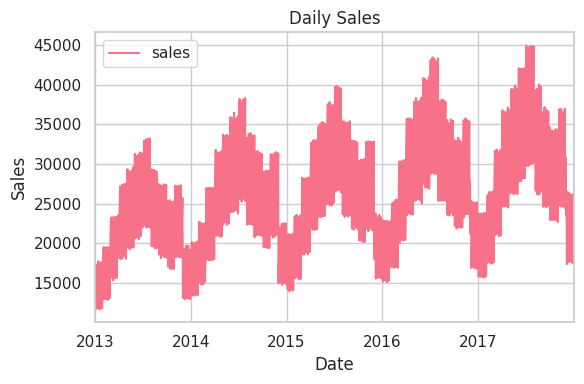

In [12]:
# Plot the 'sales' column from the 'daily_sales' DataFrame
# The 'color=palette[0]' sets the color of the plot using the first color from the 'palette' list
daily_sales.plot(x='date', y='sales', color=palette[0])

# Set the title of the plot
plt.title('Daily Sales')

# Set the x-axis label
plt.xlabel('Date')

# Set the y-axis label
plt.ylabel('Sales')

# Display the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [13]:
df['sales'].describe()

,sales
count,913000.000000
mean,52.250287
std,28.801144
min,0.000000
25%,30.000000
50%,47.000000
75%,70.000000
max,231.000000


**Observaciones 💡 -->**
> - Entre 2013 y 2017, se registraron 913,000 ventas, con una media de 52.25 unidades vendidas por transacción. El valor mínimo fue 0 y el máximo alcanzó las 231 unidades. La dispersión de los datos, medida por la desviación estándar, es de 28.8, lo que indica una variabilidad moderada.

> - El 25% de las ventas estuvo por debajo de 30 unidades, mientras que el 75% superó las 70. La mediana, de 47 unidades, señala que la mitad de las transacciones se realizaron por debajo de este valor. Los datos reflejan una distribución asimétrica hacia la derecha debido al valor máximo elevado.

In [14]:
# Initialize the MinMaxScaler to scale the values to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler to the 'sales' column and transform the data
# Reshape the 'sales' values to a 2D array with one column
df['sales'] = scaler.fit_transform(df['sales'].values.reshape(-1, 1))

**Observaciones 💡 -->**
> - Al escalar los valores con MinMaxScaler, se garantiza que la red neuronal funcione de manera más eficiente. Sin la normalización, características con rangos más amplios pueden dominar en el proceso de entrenamiento, lo que resulta en una convergencia más lenta y un rendimiento inferior del modelo.

> - Además, al escalar los valores de 'sales', se evita que los valores altos o bajos influyan desproporcionadamente en los coeficientes o pesos del modelo.

***
#### **(2) Data Preprocessing**
***

In [15]:
# Step 1: Sort the DataFrame by the 'date' column to ensure correct time ordering.
df = df.sort_values('date')

# Step 2: Group the DataFrame by 'item', 'store', and 'date', with 'as_index=False' to retain the original index.
# This will group the sales data by each unique combination of item, store, and date.
df = df.groupby(['item', 'store', 'date'], as_index=False)

# Step 3: Aggregate the 'sales' column by calculating the mean for each group.
# This summarizes sales data by computing the average sales for each unique combination of item, store, and date.
df = df.agg({'sales': ['mean']})

# Step 4: Rename the resulting columns.
# After aggregation, the columns have multi-level names (e.g., 'sales', 'mean'), so we flatten them into simple column names.
df.columns = ['item', 'store', 'date', 'sales']

# Step 5: Display the first few rows of the DataFrame to check the results.
df.head()

,item,store,date,sales
0,1,1,2013-01-01,0.056277
1,1,1,2013-01-02,0.047619
2,1,1,2013-01-03,0.060606
3,1,1,2013-01-04,0.056277
4,1,1,2013-01-05,0.043290


***
##### **(1) Data Splitting Process**
***

In [16]:
# Calculate the date 6 months ago
val_split_date = max_date - pd.DateOffset(months = 6)

# Calculate the date 6 months ago
test_split_date = max_date - pd.DateOffset(months = 3)

In [17]:
# Split the DataFrame into training, validation, and test sets
train = df[df['date'] < val_split_date]
validation = df[(df['date'] >= val_split_date) & (df['date'] < test_split_date)]
test = df[df['date'] >= test_split_date]

In [18]:
train

,item,store,date,sales
0,1,1,2013-01-01,0.056277
1,1,1,2013-01-02,0.047619
2,1,1,2013-01-03,0.060606
3,1,1,2013-01-04,0.056277
4,1,1,2013-01-05,0.043290
...,...,...,...,...
912810,50,10,2017-06-25,0.463203
912811,50,10,2017-06-26,0.354978
912812,50,10,2017-06-27,0.359307
912813,50,10,2017-06-28,0.393939


In [19]:
# Display the split DataFrames
print("Training Set:")
print(train.tail())
print(f"Training set shape: {train.shape}")

Training Set:
        item  store       date     sales
912810    50     10 2017-06-25  0.463203
912811    50     10 2017-06-26  0.354978
912812    50     10 2017-06-27  0.359307
912813    50     10 2017-06-28  0.393939
912814    50     10 2017-06-29  0.528139
Training set shape: (820500, 4)


In [20]:
print("Validation Set:")
print(validation.head())
print(f"Validation set shape: {validation.shape}")

Validation Set:
      item  store       date     sales
1641     1      1 2017-06-30  0.121212
1642     1      1 2017-07-01  0.134199
1643     1      1 2017-07-02  0.164502
1644     1      1 2017-07-03  0.077922
1645     1      1 2017-07-04  0.099567
Validation set shape: (46000, 4)


In [21]:
print("Test Set:")
print(test.head())
print(f"Test set shape: {test.shape}")

Test Set:
      item  store       date     sales
1733     1      1 2017-09-30  0.129870
1734     1      1 2017-10-01  0.090909
1735     1      1 2017-10-02  0.051948
1736     1      1 2017-10-03  0.077922
1737     1      1 2017-10-04  0.064935
Test set shape: (46500, 4)


**Observaciones 💡 -->**
> - Se ha dividido el conjunto de datos en tres subconjuntos: entrenamiento, validación y prueba. Los datos más recientes, que correspondientes a los últimos tres meses, se destinaron al conjunto de prueba, mientras que el conjunto de validación abarca los meses entre 3 y 6 meses atrás.

***
##### **(2) Sequence Generation**
***

In [22]:
WINDOW = 30
LAG = 90

In [23]:
def create_sequences(df, window, lag):
    # Initialize empty lists to store input sequences (X) and corresponding targets (y)
    X = []
    y = []

    # Loop through the dataframe to create sequences
    for i in range(len(df) - window - lag + 1):
        # Append a sequence of 'window' number of sales values to X
        X.append(df['sales'].values[i:(i + window)])

        # Append the target value, which is the sales value at the position
        # after the current window, plus the lag
        y.append(df['sales'].values[i + window + lag - 1])

    # Convert lists X and y to NumPy arrays and return them
    return np.array(X), np.array(y)

In [24]:
# Create sequences and targets for each dataset
X_train, y_train = create_sequences(train, WINDOW, LAG)
X_val, y_val = create_sequences(validation, WINDOW, LAG)
X_test, y_test = create_sequences(test, WINDOW, LAG)

### **(3) Designing and Developing the Model 🖊**

***
#### **(1) Model Selection**
***

In [25]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, BatchNormalization
from keras.optimizers import Adam

**Observaciones 💡 -->**
> - La arquitectura de **Memoria a Largo y Corto Plazo (LSTM)** es una variante de las redes neuronales recurrentes (RNN) diseñada para procesar datos secuenciales. Esta estructura es especialmente eficaz para manejar series temporales, donde la información está interrelacionada a lo largo del tiempo. Al igual que en un texto donde las palabras dependen unas de otras para dar sentido a una oración, en una serie temporal, los valores futuros a menudo dependen de los valores pasados *(Tam, A., 2023)*

> - Se considera que la LSTM es ideal para este problema porque puede recordar información durante períodos prolongados y, al mismo tiempo, olvidar datos irrelevantes, lo que le permite captar patrones y tendencias a largo plazo sin perder de vista los detalles a corto plazo.

En base a lo anteriormente mencionado, se justifica la elección de este tipo de modelo para la presente tarea a realizar.

---
##### **(4) Model Architecture**
---

In [26]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units = 64, return_sequences=True, input_shape=(X_train.shape[1], 1)))  # Increase units for the first layer
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(LSTM(units = 32, return_sequences=True))  # Reduce units for the second layer
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(LSTM(units = 16))  # Further reduce units for the third layer
model.add(Dropout(0.2))

model.add(Dense(units=1, activation='linear'))  # Linear activation for regression

---
##### **(5) Model Training**
---

In [27]:
# Define the optimizer
opt = keras.optimizers.Adam(learning_rate=0.005)

In [28]:
# Compile the model
model.compile(optimizer= opt, loss='mean_squared_error')

In [29]:
# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 32)              │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 30, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,849 (128.32 KB)

 Trainable params: 32,657 (127.57 KB)

 Non-trainable params: 192 (768.00 B)

**Observaciones 💡 -->**
> - Esta arquitectura está diseñada para abordar tareas de predicción de series temporales. Comienza con una capa LSTM que procesa las secuencias de datos, manteniendo 128 unidades para capturar patrones complejos. Luego, se aplica normalización por lotes para estabilizar el aprendizaje y se incorpora una capa de dropout para prevenir el sobreajuste. Después, hay una segunda capa LSTM con 64 unidades que refina aún más la información, seguida de otra normalización y dropout. Finalmente, una tercera capa LSTM reduce la salida a 32 unidades antes de pasar a la capa densa final, que produce una sola predicción.

In [30]:
epochs = 5  # For better result increase the epochs
batch_size = 16

In [31]:
# Fit the model
history = model.fit(X_train, y_train, epochs = epochs, validation_data = (X_val, y_val),
                    batch_size = X_train.shape[0] // batch_size)

Epoch 1/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 73s 4s/step - loss: 0.1866 - val_loss: 0.0743
Epoch 2/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - loss: 0.0246 - val_loss: 0.0277
Epoch 3/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - loss: 0.0127 - val_loss: 0.0210
Epoch 4/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - loss: 0.0108 - val_loss: 0.0213
Epoch 5/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - loss: 0.0099 - val_loss: 0.0212


---
##### **(5) Model Evaluation**
---

In [32]:
# Make predictions using the trained model on the test set
predictions = model.predict(X_test)

1450/1450 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


In [33]:
# Evaluate the model
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, predictions)))

Test RMSE: 0.11491747259024822


**Observaciones 💡 -->**
> - El **RMSE** de 0.1149 indica que, en promedio, las predicciones del modelo se desvían aproximadamente 11.49% de los valores reales. Este valor es relativamente bajo, sugiriendo que el modelo tiene un buen desempeño en la predicción.

## **[Task 2]**

## **[References]**
> - Tam, A. (2023, April 7). LSTM for time series prediction in PyTorch. MachineLearningMastery.com. https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/